In [1]:
%matplotlib inline


# Machine learning with missing values

Here we use simulated data to understanding the fundamentals of statistical
learning with missing values.

This notebook reveals why a HistGradientBoostingRegressor (
:class:`sklearn.ensemble.HistGradientBoostingRegressor` ) is a choice to
predict with missing values.

We use simulations to control the missing-value mechanism, and inspect
it's impact on predictive models. In particular, standard imputation
procedures can reconstruct missing values without distortion only if the
data is *missing at random*.

The mathematical details behind this notebook can be found in
https://arxiv.org/abs/1902.06931


## The fully-observed data: a toy regression problem

We consider a simple regression problem where X (the data) is bivariate
gaussian, and y (the prediction target)  is a linear function of the first
coordinate, with noise.

### The data-generating mechanism



In [2]:
import numpy as np

def generate_without_missing_values(n_samples, rng=42):
    mean = [0, 0]
    cov = [[1, 0.5], [0.5, 1]]
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)
    X = rng.multivariate_normal(mean, cov, size=n_samples)

    epsilon = 0.1 * rng.randn(n_samples)
    y = X[:, 0] + epsilon

    return X, y

A quick plot reveals what the data looks like



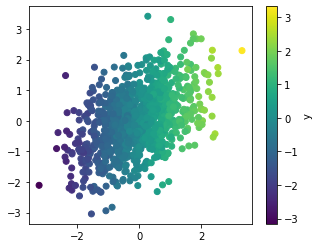

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4) # Smaller default figure size

plt.figure()
X_full, y_full = generate_without_missing_values(1000)
plt.scatter(X_full[:, 0], X_full[:, 1], c=y_full)
plt.colorbar(label='y')

## Missing completely at random settings

We now consider missing completely at random settings (a special case
of missing at random): the missingness is completely independent from
the values.

### The missing-values mechanism



In [4]:
def generate_mcar(n_samples, missing_rate=.5, rng=42):
    X, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    M = rng.binomial(1, missing_rate, (n_samples, 2))
    np.putmask(X, M, np.nan)

    return X, y

A quick plot to look at the data



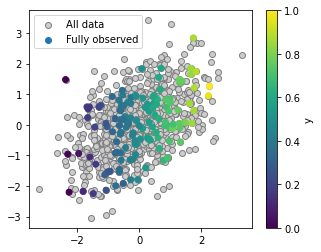

In [5]:
X, y = generate_mcar(500)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y')
plt.scatter(X[:, 0], X[:, 1], c=y, label='Fully observed')
plt.legend()

We can see that the distribution of the fully-observed data is the same
than that of the original data

### Conditional Imputation with the IterativeImputer

As the data is MAR (missing at random), an imputer can use the
conditional dependencies between the observed and the missing values to
impute the missing values.

We'll use the IterativeImputer, a good imputer, but it needs to be enabled



In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
iterative_imputer = impute.IterativeImputer()

Let us try the imputer on the small data used to visualize

**The imputation is learned by fitting the imputer on the data with
missing values**



In [7]:
iterative_imputer.fit(X)

IterativeImputer()

**The data are imputed with the transform method**



In [8]:
X_imputed = iterative_imputer.transform(X)

We can display the imputed data as our previous visualization



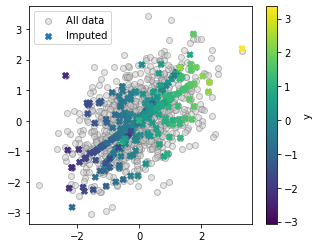

In [9]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data', alpha=.5)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, marker='X',
            label='Imputed')
plt.colorbar(label='y')
plt.legend()

We can see that the imputer did a fairly good job of recovering the
data distribution

### Supervised learning: imputation and a linear model

Given that the relationship between the fully-observed X and y is a
linear relationship, it seems natural to use a linear model for
prediction. It must be adapted to missing values using imputation.

To use it in supervised setting, we will pipeline it with a linear
model, using a ridge, which is a good default linear model



In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

iterative_and_ridge = make_pipeline(impute.IterativeImputer(), RidgeCV())

We can evaluate the model performance in a cross-validation loop
(for better evaluation accuracy, we increase slightly the number of
folds to 10)



In [11]:
from sklearn import model_selection
scores_iterative_and_ridge = model_selection.cross_val_score(
    iterative_and_ridge, X, y, cv=10)

scores_iterative_and_ridge

array([0.46386365, 0.31905505, 0.62796809, 0.50172353, 0.5526797 ,
       0.52067976, 0.66790152, 0.71185873, 0.52386641, 0.45218862])

**Computational cost**: One drawback of the IterativeImputer to keep in
mind is that its computational cost can become prohibitive of large
datasets (it has a bad computation scalability).



### Mean imputation: SimpleImputer

We can try a simple imputer: imputation by the mean



In [12]:
mean_imputer = impute.SimpleImputer()

A quick visualization reveals a larger disortion of the distribution



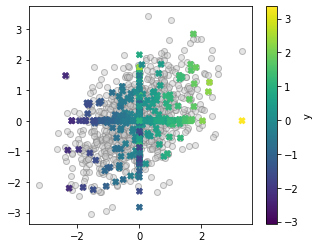

In [13]:
X_imputed = mean_imputer.fit_transform(X)
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data', alpha=.5)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, marker='X',
            label='Imputed')
plt.colorbar(label='y')

Evaluating in prediction pipeline



In [14]:
mean_and_ridge = make_pipeline(impute.SimpleImputer(), RidgeCV())
scores_mean_and_ridge = model_selection.cross_val_score(
    mean_and_ridge, X, y, cv=10)

scores_mean_and_ridge

array([0.54614659, 0.43926104, 0.59187943, 0.44029222, 0.53507246,
       0.41132337, 0.67374847, 0.79018856, 0.48898176, 0.46854395])

### Supervised learning without imputation

The HistGradientBoosting models are based on trees, which can be
adapted to model directly missing values



In [15]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
score_hist_gradient_boosting = model_selection.cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

score_hist_gradient_boosting

/home/varoquau/dev/scikit-learn/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


array([0.48104853, 0.3676542 , 0.54779672, 0.43052366, 0.53230889,
       0.31475748, 0.66549077, 0.70964002, 0.5001503 , 0.43511816])

### Recap: which pipeline predicts well on our small data?

Let's plot the scores to see things better



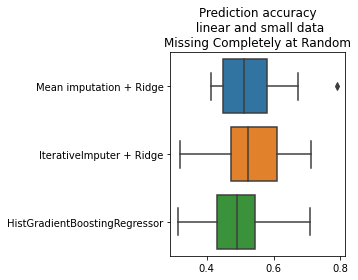

In [16]:
import pandas as pd
import seaborn as sns

scores = pd.DataFrame({'Mean imputation + Ridge': scores_mean_and_ridge,
             'IterativeImputer + Ridge': scores_iterative_and_ridge,
             'HistGradientBoostingRegressor': score_hist_gradient_boosting,
    })

sns.boxplot(data=scores, orient='h')
plt.title('Prediction accuracy\n linear and small data\n'
          'Missing Completely at Random')
plt.tight_layout()

Not much difference with the more sophisticated imputer. A more thorough
analysis would be necessary, with more cross-validation runs.

### Prediction performance with large datasets

Let us compare models in regimes where there is plenty of data



In [17]:
X, y = generate_mcar(n_samples=20000)

Iterative imputation and linear model



In [18]:
scores_iterative_and_ridge= model_selection.cross_val_score(
    iterative_and_ridge, X, y, cv=10)

Mean imputation and linear model



In [19]:
scores_mean_and_ridge = model_selection.cross_val_score(
    mean_and_ridge, X, y, cv=10)

And now the HistGradientBoostingRegressor, which does not need
imputation



In [20]:
score_hist_gradient_boosting = model_selection.cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

We plot the results



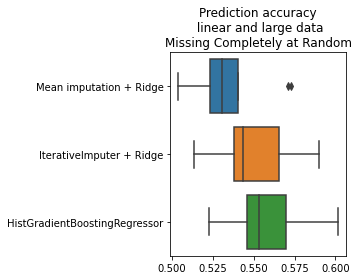

In [21]:
scores = pd.DataFrame({'Mean imputation + Ridge': scores_mean_and_ridge,
             'IterativeImputer + Ridge': scores_iterative_and_ridge,
             'HistGradientBoostingRegressor': score_hist_gradient_boosting,
    })

sns.boxplot(data=scores, orient='h')
plt.title('Prediction accuracy\n linear and large data\n'
          'Missing Completely at Random')
plt.tight_layout()

**When there is a reasonnable amount of data, the
HistGradientBoostingRegressor is the best strategy** even for a linear
data-generating mechanism, in MAR settings, which are settings
favorable to imputation + linear model [#]_.

.. [#] Even in the case of a linear data-generating mechanism, the
       optimal prediction one data imputed by a constant
       is a piecewise affine function with 2^d regions (
       http://proceedings.mlr.press/v108/morvan20a.html ). The
       larger the dimensionality (number of features), the more a
       imperfect imputation is hard to approximate with a simple model.

|



## Missing not at random: censoring

We now consider missing not at random settings, in particular
self-masking or censoring, where large values are more likely to be
missing.

### The missing-values mechanism



In [22]:
def generate_censored(n_samples, missing_rate=.4, rng=42):
    X, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    B = rng.binomial(1, 2 * missing_rate, (n_samples, 2))
    M = (X > 0.5) * B

    np.putmask(X, M, np.nan)

    return X, y

A quick plot to look at the data



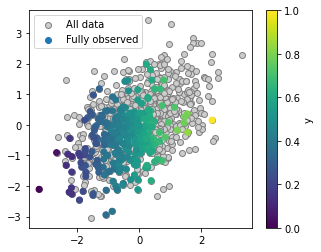

In [23]:
X, y = generate_censored(500, missing_rate=.4)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data')
plt.colorbar(label='y')
plt.scatter(X[:, 0], X[:, 1], c=y, label='Fully observed')
plt.legend()

Here the full-observed data does not reflect well at all the
distribution of all the data



### Imputation fails to recover the distribution

With MNAR data, off-the-shelf imputation methods do not recover the
initial distribution:



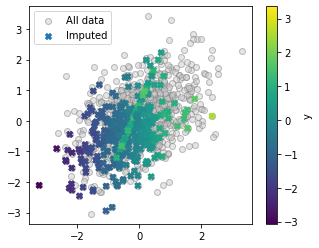

In [24]:
iterative_imputer = impute.IterativeImputer()
X_imputed = iterative_imputer.fit_transform(X)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data', alpha=.5)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, marker='X',
            label='Imputed')
plt.colorbar(label='y')
plt.legend()

Recovering the initial data distribution would need much more mass on
the right and the top of the figure. The imputed data is shifted to
lower values than the original data.

Note also that as imputed values typically have lower X values than
their full-observed counterparts, the association between X and y is
also distorted. This is visible as the imputed values appear as lighter
diagonal lines.

An important consequence is that **the link between imputed X and y is no
longer linear**, although the original data-generating mechanism is
linear [#]_. For this reason, **it is often a good idea to use non-linear
learners in the presence of missing values**.

.. [#] As mentionned above, even in the case of a linear
   data-generating mechanism, imperfect imputation leads to complex
   functions to link to y (
   http://proceedings.mlr.press/v108/morvan20a.html )



### Predictive pipelines

Let us now evaluate predictive pipelines



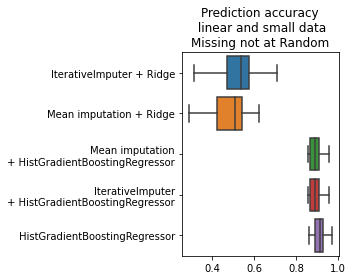

In [25]:
scores = dict()

# Iterative imputation and linear model
scores['IterativeImputer + Ridge'] = model_selection.cross_val_score(
    iterative_and_ridge, X, y, cv=10)

# Mean imputation and linear model
scores['Mean imputation + Ridge'] = model_selection.cross_val_score(
    mean_and_ridge, X, y, cv=10)

# IterativeImputer and non-linear model
iterative_and_gb = make_pipeline(impute.SimpleImputer(),
                            HistGradientBoostingRegressor())
scores['Mean imputation\n+ HistGradientBoostingRegressor'] = model_selection.cross_val_score(
    iterative_and_gb, X, y, cv=10)

# Mean imputation and non-linear model
mean_and_gb = make_pipeline(impute.SimpleImputer(),
                            HistGradientBoostingRegressor())
scores['IterativeImputer\n+ HistGradientBoostingRegressor'] = model_selection.cross_val_score(
    mean_and_gb, X, y, cv=10)

# And now the HistGradientBoostingRegressor, whithout imputation
scores['HistGradientBoostingRegressor'] = model_selection.cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

# We plot the results
sns.boxplot(data=pd.DataFrame(scores), orient='h')
plt.title('Prediction accuracy\n linear and small data\n'
          'Missing not at Random')
plt.tight_layout()

We can see that the imputation is not the most important step of the
pipeline [#]_, rather **what is important is to use a powerful model**.

.. [#] Note that there are less missing values in the example here
   compared to the section above on MCAR, hence the absolute prediction
   accuracies are not comparable.



.. topic:: Prediction with missing values

  The data above are very simple: linear data-generating mechanism,
  Gaussian, and low dimensional. Yet, they show the importance of using
  non-linear models, in particular the HistGradientBoostingRegressor
  which natively deals with missing values.



## Using a predictor for the fully-observed case

Let us go back to the "easy" case of the missing completely at random
settings with plenty of data



In [ ]:
n_samples = 20000

X, y = generate_mcar(n_samples, missing_rate=.5)

Suppose we have been able to train a predictive model that works on
fully-observed data:



In [ ]:
X_full, y_full = generate_without_missing_values(n_samples)
full_data_predictor = HistGradientBoostingRegressor()
full_data_predictor.fit(X_full, y_full)

model_selection.cross_val_score(full_data_predictor, X_full, y_full)

The cross validation reveals that the predictor achieves an excellent
explained variance; it is a near-perfect predictor on fully observed
data



Now we turn to data with missing values. Given that our data is MAR
(missing at random), we will use imputation to build a completed data
that looks like the full-observed data



In [ ]:
iterative_imputer = impute.IterativeImputer()
X_imputed = iterative_imputer.fit_transform(X)

The full data predictor can be used on the imputed data



In [ ]:
from sklearn import metrics
metrics.r2_score(y, full_data_predictor.predict(X_imputed))

This prediction is less good than on the full data, but this is
expected, as missing values lead to a loss of information. We can
compare it to a model trained to predict on data with missing values



In [ ]:
X_train, y_train = generate_mcar(n_samples, missing_rate=.5)
na_predictor = HistGradientBoostingRegressor()
na_predictor.fit(X_train, y_train)

metrics.r2_score(y, na_predictor.predict(X))

Applying a model valid on the full data to imputed data work almost
as well as a model trained for missing values. The small loss in
performance is because the imputation is imperfect.



### When the data-generation is non linear

We now modify a bit the example above to consider the situation where y
is a non-linear function of X



In [ ]:
X, y = generate_mcar(n_samples, missing_rate=.5)
y = y ** 2

# Train a predictive model that works on fully-observed data:
X_full, y_full = generate_without_missing_values(n_samples)
y_full = y_full ** 2
full_data_predictor = HistGradientBoostingRegressor()
full_data_predictor.fit(X_full, y_full)

model_selection.cross_val_score(full_data_predictor, X_full, y_full)

Once again, we have a near-perfect predictor on fully-observed data

On data with missing values:



In [ ]:
iterative_imputer = impute.IterativeImputer()
X_imputed = iterative_imputer.fit_transform(X)

from sklearn import metrics
metrics.r2_score(y, full_data_predictor.predict(X_imputed))

The full-data predictor works much less well

Now we use a model trained to predict on data with missing values



In [ ]:
X_train, y_train = generate_mcar(n_samples, missing_rate=.5)
y_train = y_train ** 2
na_predictor = HistGradientBoostingRegressor()
na_predictor.fit(X_train, y_train)

metrics.r2_score(y, na_predictor.predict(X))

The model trained on data with missing values works significantly
better than that that was optimal for the fully-observed data.

**Only for linear mechanism is the model on full data also optimal for
prefectly imputed data**. When the function linking X to y has
curvature, this curvature turns uncertainty resulting from missingness
into bias [#]_.

.. [#] The detailed mathematical analysis of prediction after
   imputation can be found here: https://arxiv.org/abs/2106.00311

|

________

